In [1]:
import csv
import numpy as np
import mpmath as mp #problem with mp!
import matplotlib.pyplot as plt
from scipy.integrate import simps,cumtrapz
import astropy.cosmology as co
import astropy.units as u
import astropy.constants as const
import pandas as pd

In [2]:
#%config InlineBackend.figure_format = 'retina'
#plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if int(base)==1:
            return r"10^{{{0}}}".format(int(exponent))
        if int(base)==-1:
            return r"-10^{{{0}}}".format(int(exponent))
        else:
            return r"{0} \cdot 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
print('latex test: '+latex_float(1.0e9), latex_float(-1e-9))

latex test: 10^{9} -10^{-9}


In [3]:
H0kmsMpc = 70*u.km/u.s/u.Mpc
cosmo = co.FlatLambdaCDM(H0kmsMpc,0.307)
def tau_einst_int(z_s):
    ''' standard lensing optical depth integral (dimensionless)'''
    z_p = np.linspace(1e-3*z_s,z_s,100)
    DL = cosmo.angular_diameter_distance(z_p)
    DLS = cosmo.angular_diameter_distance_z1z2(z_p,z_s*np.ones(len(z_p)))
    DS = cosmo.angular_diameter_distance(z_s)
    #convert by hand
    H = cosmo.H(z_p)/(3e5*u.km/u.s)
    H0 = cosmo.H(0)/(3e5*u.km/u.s)
    integrand = H0**2*(1+z_p)**2/H*(DL*DLS/DS)
    return simps(integrand,x=z_p)

tau_einst_int = np.vectorize(tau_einst_int)

def tau_phys_int(z_s):
    '''optical depth integral for fix physical radius (not comoving)'''
    z_p = np.linspace(1e-3*z_s,z_s,100)
    #DL = cosmo.angular_diameter_distance(z_p)
    #DLS = cosmo.angular_diameter_distance_z1z2(z_p,z_s)
    #DS = cosmo.angular_diameter_distance(z_s)
    #convert by hand
    H = cosmo.H(z_p)/(3e5*u.km/u.s)
    H0 = cosmo.H(0)/(3e5*u.km/u.s)
    integrand = H0*(1+z_p)**2/H
    return simps(integrand,x=z_p)

tau_phys_int = np.vectorize(tau_phys_int)

def dL2z(dL,zmax=2):
    ''' return z for a given d_L, cosmo is an astropy cosmology class'''
    zs = np.geomspace(1e-2,zmax,100)
    dLs = cosmo.luminosity_distance(zs)
    
    #z = griddata(dLs,zs,dL)
    z=np.interp(dL,dLs.value,zs)
    return z

In [4]:
dL=200
zs = np.geomspace(1e-2,2,100)
dLs = cosmo.luminosity_distance(zs)
    
    #z = griddata(dLs,zs,dL)
z=np.interp(dL,dLs.value,zs)

In [ ]:
events_df_info=pd.read_csv('events_df_info.csv')
events_df_info.tail()

Unnamed: 0  Unnamed: 0.1 CatDev Name     SNAME         FULLNAME  \
83          83            83   GW200308A  S200308a  GW200308_173609   
84          84            84   GW200311B  S200311b  GW200311_115853   
85          85            85   GW200316A  S200316a  GW200316_215756   
86          86            86   GW200322A  S200322a  GW200322_091133   
87          87            87   GW200326A  S200326a  GW200326_112501   

              NNAME  MINIMALNAME GRACEDBSID  IS PUBLIC?  CWB ONLY?  ...  \
83  GW200308_173609     GW200308  S200308bl       False      False  ...   
84  GW200311_115853  GW200311_11  S200311bg        True      False  ...   
85  GW200316_215756     GW200316  S200316bj        True      False  ...   
86  GW200322_091133     GW200322  S200322ab       False      False  ...   
87  GW200326_112501     GW200326  S200326af       False       True  ...   

     mass2 L1  mchirp L1   mtotal L1  template_duration L1    snr V1  \
83  34.847599  41.906761  102.818770              4.399324  2.133489   
84  32.121094  29.053270   66.805939              2.704791  7.292044   
85   4.943711  10.775739   41.868874             11.333138  3.119627   
86  15.137034  24.386002   71.318713              0.720487  2.242833   
87        NaN        NaN         NaN                   NaN       NaN   

     mass1 V1   mass2 V1  mchirp V1   mtotal V1  template_duration V1  
83  67.971169  34.847599  41.906761  102.818770              4.399324  
84  34.684841  32.121094  29.053270   66.805939              2.704791  
85  36.925163   4.943711  10.775739   41.868874             11.333138  
86  56.181679  15.137034  24.386002   71.318713              0.720487  
87        NaN        NaN        NaN         NaN                   NaN  

[5 rows x 30 columns]

In [ ]:
dict_grace_fullname = dict(zip(events_df_info['NNAME'],events_df_info['GRACEDBSID']))
#dict_grace_fullname

In [7]:
# Read data and construct sub-catalogue
#reader = csv.DictReader(open('gwtc.csv'))
reader=pd.read_csv('gwtc.csv')
reader = reader[reader['luminosity_distance'].notna()].reset_index(drop=True)
#print(gw_z_data)
events_tested = ['GW200129_065458', 'GW190412', 'GW200112_155838', 'GW200224_222234', 'GW190521_074359']
subcatalogue = []
subcat_zs = []
print ('name' , 'luminosity_distance', 'z', 'network_matched_filter_snr')
reader=reader[reader['far']<1e-3][9:].reset_index(drop=True)
for i in range(len(reader)):
    row = reader.loc[i]
    if 1:#row['commonName']  in events_tested:
        subcatalogue.append(row)
        z = dL2z(np.float64(row['luminosity_distance']))
        subcat_zs.append(z)
        print (row['commonName'] , row['luminosity_distance'], '%.3g'%z, '%.4g'%float(row['network_matched_filter_snr']))

factor = 3 #factor at which the exclusion can be placed, from poisson statistics CDF = exp(-tau) = 0.05
#subcatalogue and associated fiducials
subcat_zs = np.array(subcat_zs)
tau_phys=tau_phys_int(subcat_zs)
#print ('tau_phys (R_x=22_kpc)', np.sum(tau_phys))
tau_einst=tau_einst_int(subcat_zs)
#print('tau_einst (alpha=1)', np.sum(tau_einst))

Om = 0.3 #Omega_m
h = 0.7

RX_O2_kpc = 22./np.sqrt(np.sum(h*Om*tau_phys)/factor)
alphaX_O2 = 1/np.sqrt(np.sum(1.5*Om*tau_einst)/factor)
print('-----------------------------------------')
print ('RX > %.3g'%RX_O2_kpc, 'kpc excluded (95%)', ' tau_tot = %.3g'%np.sum(tau_phys))
print ('alphaX > %.3g'%alphaX_O2, ' excluded (95%)', 'tau_tot = %.3g'%np.sum(tau_einst))

name luminosity_distance z network_matched_filter_snr
GW190408_181802 1550.0 0.3 14.67
GW190412 740.0 0.155 18.86
GW190421_213856 2880.0 0.508 10.55
GW190425 160.0 0.0364 13.03
GW190503_185404 1450.0 0.283 12.1
GW190512_180714 1430.0 0.28 12.26
GW190513_205428 2060.0 0.383 12.29
GW190517_055101 1860.0 0.351 10.24
GW190519_153544 2530.0 0.456 12.05
GW190521 3920.0 0.656 14.38
GW190521_074359 1240.0 0.247 24.38
GW190602_175927 2690.0 0.48 12.13
GW190630_185205 890.0 0.184 15.64
GW190706_222641 4420.0 0.723 12.35
GW190707_093326 770.0 0.161 12.98
GW190708_232457 880.0 0.182 13.07
GW190720_000836 790.0 0.165 11.7
GW190727_060333 3300.0 0.569 12.3
GW190728_064510 870.0 0.18 13.64
GW190814 240.0 0.0538 22.18
GW190828_063405 2130.0 0.394 16.04
GW190828_065509 1600.0 0.308 11.13
GW190910_112807 1460.0 0.285 13.42
GW190915_235702 1620.0 0.312 13.07
GW190924_021846 570.0 0.122 13.16
GW191109_010717 1290.0 0.255 17.3
GW191129_134029 790.0 0.165 13.1
GW191204_171526 650.0 0.138 17.5
GW191215_22305

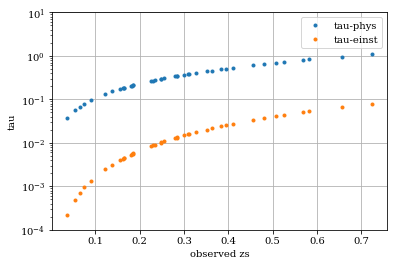

In [8]:
import matplotlib.pylab as plt
plt.plot(subcat_zs,tau_phys,'.',label='tau-phys')
plt.plot(subcat_zs,tau_einst,'.',label='tau-einst')
plt.yscale('log')
plt.ylim(1e-4,1e1)
plt.legend()
plt.xlabel('observed zs')
plt.ylabel('tau')
plt.grid()
plt.show()


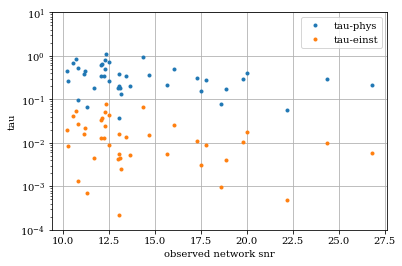

In [9]:
plt.plot(reader['network_matched_filter_snr'],tau_phys,'.',label='tau-phys')
plt.plot(reader['network_matched_filter_snr'],tau_einst,'.',label='tau-einst')
plt.yscale('log')
plt.ylim(1e-4,1e1)
plt.legend()
plt.xlabel('observed network snr')
plt.ylabel('tau')
plt.grid()
plt.show()



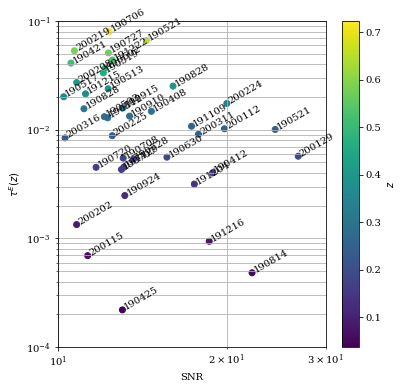

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(reader['network_matched_filter_snr'],tau_einst,c=dL2z(reader['luminosity_distance']))

plt.colorbar(label ='$z$')
#plt.plot(reader['network_matched_filter_snr'],tau_einst,'.',label='tau_einst')
plt.yscale('log')
plt.xscale('log')
for i in range(len(reader)):
    x=reader['network_matched_filter_snr'][i]
    if x< 30:
        plt.text(x,tau_einst[i],reader['commonName'][i][2:8],rotation = 30)
plt.ylim(1e-4,1e-1)
#plt.legend()
plt.xlabel('SNR')
plt.xlim(10,30)
plt.ylabel('$\\tau^{E}(z)$')
plt.grid(which='both')
plt.savefig('real_events_expected_results_tau_einst.pdf')
plt.show()

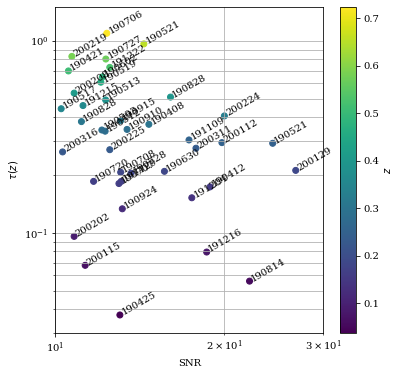

In [11]:
plt.figure(figsize=(6,6))
plt.scatter(reader['network_matched_filter_snr'],tau_phys,c=dL2z(reader['luminosity_distance']))

plt.colorbar(label ='$z$')
#plt.plot(reader['network_matched_filter_snr'],tau_einst,'.',label='tau_einst')
plt.yscale('log')
plt.xscale('log')
for i in range(len(reader)):
    x=reader['network_matched_filter_snr'][i]
    if x< 30:
        plt.text(x,tau_phys[i],reader['commonName'][i][2:8],rotation = 30)
plt.ylim(3e-2,1.5e0)
#plt.legend()
plt.xlabel('SNR')
plt.xlim(10,30)
plt.ylabel('$\\tau(z)$')
plt.grid(which='both')
plt.savefig('real_events_expected_results.pdf')
plt.show()

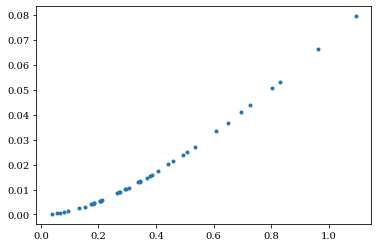

In [22]:
plt.plot(tau_phys,tau_einst,'.')

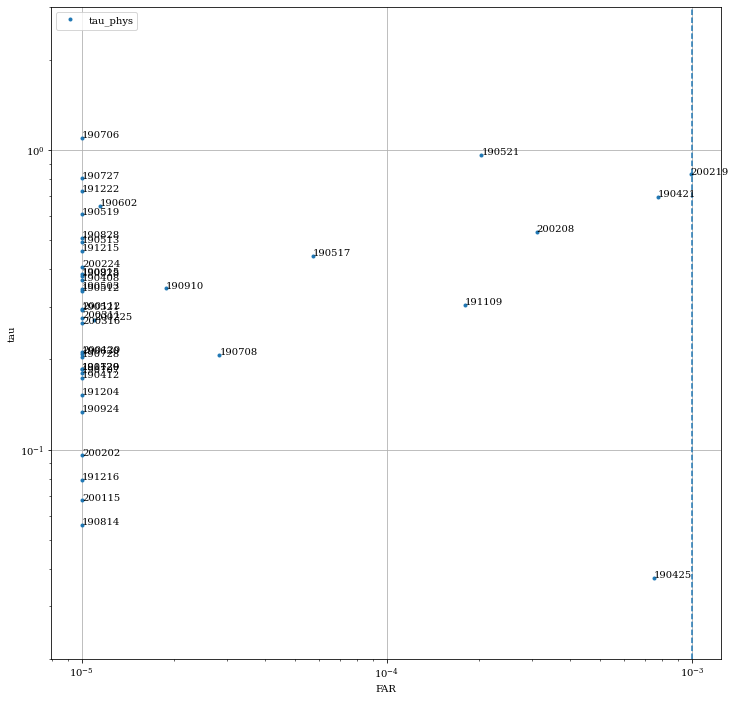

In [12]:
plt.figure(figsize=(12,12))
plt.plot(reader['far'],tau_phys,'o',ms=3,label='tau_phys')


#plt.plot(reader['network_matched_filter_snr'],tau_einst,'.',label='tau_einst')
plt.yscale('log')
plt.xscale('log')
plt.axvline(1e-3,ls='dashed')
for i in range(len(reader)):
    plt.text(reader['far'][i],tau_phys[i],reader['commonName'][i] [2:8])
plt.ylim(2e-2,3e0)
plt.legend()
plt.xlabel('FAR')
plt.ylabel('tau')
plt.grid()
plt.show()





In [13]:
reader.columns

Index(['id', 'commonName', 'version', 'catalog.shortName', 'GPS', 'reference',
       'jsonurl', 'mass_1_source', 'mass_1_source_lower',
       'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper',
       'luminosity_distance', 'luminosity_distance_lower',
       'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower',
       'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower',
       'total_mass_source_upper', 'chirp_mass_source',
       'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass',
       'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower',
       'redshift_upper', 'far', 'far_lower', 'far_upper', 'p_astro',
       'p_astro_lower', 'p_astro_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_upper'],
      dtype='object')

In [14]:
#reader[reader['network_matched_filter_snr']>10]['commonName'].reset_index()

In [15]:
events_to_consider = reader[reader['far']<1e-3].reset_index(drop=True)['commonName'].values
events_to_consider

array(['GW190408_181802', 'GW190412', 'GW190421_213856', 'GW190425',
       'GW190503_185404', 'GW190512_180714', 'GW190513_205428',
       'GW190517_055101', 'GW190519_153544', 'GW190521',
       'GW190521_074359', 'GW190602_175927', 'GW190630_185205',
       'GW190706_222641', 'GW190707_093326', 'GW190708_232457',
       'GW190720_000836', 'GW190727_060333', 'GW190728_064510',
       'GW190814', 'GW190828_063405', 'GW190828_065509',
       'GW190910_112807', 'GW190915_235702', 'GW190924_021846',
       'GW191109_010717', 'GW191129_134029', 'GW191204_171526',
       'GW191215_223052', 'GW191216_213338', 'GW191222_033537',
       'GW200112_155838', 'GW200115_042309', 'GW200129_065458',
       'GW200202_154313', 'GW200208_130117', 'GW200219_094415',
       'GW200224_222234', 'GW200225_060421', 'GW200311_115853',
       'GW200316_215756'], dtype=object)

In [16]:
(', ').join(events_to_consider)

'GW190408_181802, GW190412, GW190421_213856, GW190425, GW190503_185404, GW190512_180714, GW190513_205428, GW190517_055101, GW190519_153544, GW190521, GW190521_074359, GW190602_175927, GW190630_185205, GW190706_222641, GW190707_093326, GW190708_232457, GW190720_000836, GW190727_060333, GW190728_064510, GW190814, GW190828_063405, GW190828_065509, GW190910_112807, GW190915_235702, GW190924_021846, GW191109_010717, GW191129_134029, GW191204_171526, GW191215_223052, GW191216_213338, GW191222_033537, GW200112_155838, GW200115_042309, GW200129_065458, GW200202_154313, GW200208_130117, GW200219_094415, GW200224_222234, GW200225_060421, GW200311_115853, GW200316_215756'

In [17]:
o3_graceids=[dict_grace_fullname[name] for name in events_to_consider]
print(*o3_graceids, sep='\n')

S190408an
S190412m
S190421ar
S190425z
S190503bf
S190512at
S190513bm
S190517h
S190519bj
S190521g
S190521r
S190602aq
S190630ag
S190706ai
S190707q
S190708ap
S190720a
S190727h
S190728q
S190814bv
S190828j
S190828l
S190910s
S190915ak
S190924h
S191109d
S191129u
S191204r
S191215w
S191216ap
S191222n
S200112r
S200115j
S200129m
S200202ac
S200208q
S200219ac
S200224ca
S200225q
S200311bg
S200316bj


In [18]:
len(o3_graceids)

41

In [19]:
reader.columns

Index(['id', 'commonName', 'version', 'catalog.shortName', 'GPS', 'reference',
       'jsonurl', 'mass_1_source', 'mass_1_source_lower',
       'mass_1_source_upper', 'mass_2_source', 'mass_2_source_lower',
       'mass_2_source_upper', 'network_matched_filter_snr',
       'network_matched_filter_snr_lower', 'network_matched_filter_snr_upper',
       'luminosity_distance', 'luminosity_distance_lower',
       'luminosity_distance_upper', 'chi_eff', 'chi_eff_lower',
       'chi_eff_upper', 'total_mass_source', 'total_mass_source_lower',
       'total_mass_source_upper', 'chirp_mass_source',
       'chirp_mass_source_lower', 'chirp_mass_source_upper', 'chirp_mass',
       'chirp_mass_lower', 'chirp_mass_upper', 'redshift', 'redshift_lower',
       'redshift_upper', 'far', 'far_lower', 'far_upper', 'p_astro',
       'p_astro_lower', 'p_astro_upper', 'final_mass_source',
       'final_mass_source_lower', 'final_mass_source_upper'],
      dtype='object')

# approximate expected results

## all gwtc events
RX > 12.2 kpc excluded (95%)  tau_tot = 46.4

alphaX > 1.56  excluded (95%) tau_tot = 2.74

## tested events
RX > 70.8 kpc excluded (95%)  tau_tot = 1.38

alphaX > 11.9  excluded (95%) tau_tot = 0.0475

## events having FAR <1e-3

RX > 20.2 kpc excluded (95%)  tau_tot = 16.9

alphaX > 2.92  excluded (95%) tau_tot = 0.782


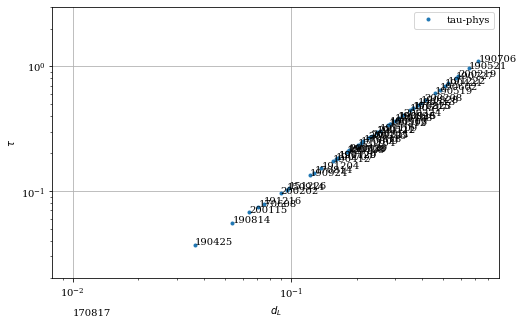

In [18]:
plt.figure(figsize=(8,5))
plt.plot(dL2z(reader['luminosity_distance']),tau_phys,'o',ms=3,label='tau-phys')


#plt.plot(reader['network_matched_filter_snr'],tau_einst,'.',label='tau_einst')
plt.yscale('log')
plt.xscale('log')
for i in range(len(reader)):
    plt.text(dL2z(reader['luminosity_distance'][i]),tau_phys[i],reader['commonName'][i][2:8] )
plt.ylim(2e-2,3e0)
plt.legend()
plt.xlabel('$d_L$')
plt.ylabel('$\\tau$')
plt.grid()
plt.show()



